# About the notebook

The notebook is aim to 
- visualize the density of each marker in different sample / lab
- observe the effect of MPSK calibration to the distribution of marker intensities
- compare the MPSK calibration and [Per-channel basis calibration](https://www.ncbi.nlm.nih.gov/pubmed/19899135)

In [1]:
### import libraries
suppressMessages(suppressWarnings(library(tidyverse)))
suppressMessages(suppressWarnings(library(ggridges)))
suppressMessages(suppressWarnings(library(MPSK)))
suppressMessages(suppressWarnings(library(tsne)))
suppressMessages(suppressWarnings(library(pheatmap)))
suppressMessages(suppressWarnings(library(RColorBrewer)))
suppressMessages(suppressWarnings(library(flowCore)))
suppressMessages(suppressWarnings(library(flowStats)))
suppressMessages(suppressWarnings(library(flowViz)))
suppressMessages(suppressWarnings(library(flowMatch)))

### set directories
dat_dir01 = "/data/SMPK"
dat_dir02 = "/data/clintko/SMPK"

# Import data

previous code

```
%%Python
target_dir = "/data/SMPK"
with open(os.path.join(target_dir, "res0_GEN070XT_CMVpp65.pic"), 'rb') as f:
    res = pickle.load(f)

%%R -i res
resRelab      = relabelChain(res)
resCalibrated = calibrate(resRelab)
chainSummary  = summarizeChain(resRelab)
```

import results from MPSK

In [2]:
res           = readRDS(file = file.path(dat_dir02, "ep8cs_mpsk_raw.RDS"))
resRelab      = readRDS(file = file.path(dat_dir02, "ep8cs_mpsk_relab.RDS")) 
resCalibrated = readRDS(file = file.path(dat_dir02, "ep8cs_mpsk_cal.RDS"))
chainSummary  = readRDS(file = file.path(dat_dir02, "ep8cs_mpsk_chainSummary.RDS")) 

In [3]:
print(names(res))
print("=====================")
print(names(resRelab))
print("=====================")
print(names(resCalibrated))
print("=====================")
print(names(chainSummary))

[1] "chain" "data"  "prior" "pmc"  
[1] "====================="
[1] "chain" "data"  "prior" "pmc"  
[1] "====================="
[1] "Y_cal"                    "calibration_distribution"
[3] "calibration_median"      
[1] "====================="
 [1] "xi0"      "psi"      "alpha"    "W"        "xi"       "Omega"   
 [7] "Sigma"    "E"        "meanvec"  "meanvec0" "t"        "S"       
[13] "varphi"   "a0"      


the cluster label assigned by MPSK is `chainSummary$t`

In [4]:
### shape of data
print(dim(res$data$Y))
print(dim(resCalibrated$Y_cal))

### size of label should be equal to the number of observations
print(length(chainSummary$t))

[1] 180000     10
[1] 180000     10
[1] 180000


Import markers

In [5]:
markers = read_table(file.path(dat_dir01, "markers.txt"), col_names = FALSE)
markers = separate(
    markers, 
    col  = "X1", 
    into = c("label", "color", "measure"), 
    sep  = " ")
markers$color[1:2]   = c("FSC-A", "SSC-A")
markers$measure[1:2] = c("FSC-A", "SSC-A")

markers

Parsed with column specification:
cols(
  X1 = col_character()
)
Warning message:
“Expected 3 pieces. Missing pieces filled with `NA` in 2 rows [1, 2].”

label,color,measure
FSC-A,FSC-A,FSC-A
SSC-A,SSC-A,SSC-A
Aqua,Amine,FLR-A
CD3,APC-H7,FLR-A
CD4,PE-Cy7,FLR-A
CD8,PerCP-Cy55,FLR-A
TNFa,FITC,FLR-A
IL2,BV421,FLR-A
IFNg,APC,FLR-A
CD107a,PE,FLR-A


# Rearrange the results
combine the MPSK cluster label and sample label

In [6]:
### extract needed data
clust = chainSummary$t
C     = resRelab$data$C
Y     = resRelab$data$Y
Y_cal = resCalibrated$Y_cal
C2    = sapply(C, function(x){ifelse(x < 10, paste0("0", x), x)})

### assign column names
colnames(Y)     = markers$label
colnames(Y_cal) = paste(markers$label)

### raw and calibrated data
dat = cbind(C, clust, Y) %>% as.data.frame
dat$V1 = C2
colnames(dat)[1:2] = c("sample", "cluster")
dat_mpsk = dat

dat = cbind(C, clust, Y_cal) %>% as.data.frame
dat$V1 = C2
colnames(dat)[1:2] = c("sample", "cluster")
dat_mpsk_cal = dat

### observe the results
cat("=======================\n")
head(dat_mpsk)

cat("=======================\n")
head(dat_mpsk_cal)

cat("===========================")
print(table(dat_mpsk$sample))

sample,cluster,FSC-A,SSC-A,Aqua,CD3,CD4,CD8,TNFa,IL2,IFNg,CD107a
01,4,-1.1416363,-0.09986633,-0.4210673,0.7761014,2.2731346,0.6444498,-0.1937829,-0.02015737,-0.27344867,0.60710339
01,3,-0.8405893,-0.73858079,1.2407957,-0.4222472,-0.5658801,0.6557209,-0.6118518,-0.02377409,-0.34964856,-0.03757027
01,1,0.5107179,-0.84609384,-1.0598249,-0.3661789,-0.5889247,-1.8527354,-1.1840413,-0.03447264,-0.42590688,-0.02672243
01,4,-1.5681802,-0.57996979,-0.5588165,0.2319850,1.8415205,-0.1502302,-0.5595654,0.02146696,-0.51009832,-0.01391902
01,8,-1.5371229,0.32463843,-0.2535651,-0.6772130,2.0872188,-1.3166316,-0.6453749,-0.22168409,-0.88871667,0.15053694
01,1,-0.2959737,-0.29703637,-0.2005701,-0.6302307,0.4919176,-0.8454200,-0.2646515,2.44124150,0.02647195,0.33899091


sample,cluster,FSC-A,SSC-A,Aqua,CD3,CD4,CD8,TNFa,IL2,IFNg,CD107a
01,4,-0.96173656,-0.2160766,-0.8626180,0.8574500,2.0318348,0.6358294,-0.46653128,-0.4172130,-0.3461938,0.39110337
01,3,-0.82900217,-0.7012622,1.1034122,-0.7414830,-0.9433545,0.7592594,-0.52655060,-0.6186187,-0.2796178,-0.12884297
01,1,0.75371023,-0.7951407,-1.3776832,-0.6027146,-0.9719115,-2.1713238,-0.84220419,-0.7038922,-0.3091450,-0.08001407
01,4,-1.39160671,-0.6938895,-1.0015626,0.3112666,1.6011798,-0.1616408,-0.83067807,-0.3725543,-0.5801865,-0.22684893
01,8,-1.40720126,0.2935883,-0.7124403,-0.8000352,1.8639001,-1.5923484,-0.72045281,-0.5326612,-0.9030198,-0.02101916
01,1,-0.05520724,-0.2477739,-0.5175293,-0.8658211,0.1091478,-1.1604910,0.07482237,1.7730925,0.1419180,0.28623963


   01    02    03    04    05    06    07    08    09    10    11    12    13 
10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 
   14    15    16    17    18 
10000 10000 10000 10000 10000 


# compare each batch removal methods
- MPSK calibration
- GaussNorm Per-channel basis calibration

Helper function for create flowFrame object

In [7]:
create_frame = function(dat, idx_sample){
    # create flowFrame object from input dataframe (dat)
    #####################################
    ### get one sample
    mat = dat %>% 
        dplyr::filter(sample == idx_sample) %>% 
        dplyr::select(-sample, -cluster) %>% 
        as.matrix
    
    ### calculate the range of each marker 
    df_range = apply(mat, 2, function(x){
        x_min   = min(x)
        x_max   = max(x)
        x_range = x_max - x_min
        res = c(x_range, x_min, x_max)
        names(res) = c("range", "minRange", "maxRange")
        return(res)
    })   
    df_range = df_range %>% t %>% as.data.frame

    ### combine marker ranges and names into AnnotatedDataFrame
    df_annot = data.frame(name = colnames(mat), desc = colnames(mat))
    df_annot = bind_cols(df_annot, df_range)  
    rownames(df_annot) = df_annot$name
    df_annot = Biobase::AnnotatedDataFrame(df_annot)

    ### create flowFrame from the intensity matrix and annotated dataframe
    frame = flowFrame(exprs = mat, parameters = df_annot)
    identifier(frame) = paste0("Sample ", idx_sample)
    
    return(frame)
} # end function

Create flowSet object from a list of flowFrame objects

In [40]:
### Create flowSet object of raw Y and C
dat = dat_mpsk
lst = lapply(unique(C2), function(idx){create_frame(dat, idx)})
names(lst) = sapply(lst, identifier)
set = flowSet(lst)

### Create flowSet object of Y_cal and C
dat = dat_mpsk_cal
lst = lapply(unique(C2), function(idx){create_frame(dat, idx)})
names(lst) = sapply(lst, identifier)
set_cal = flowSet(lst)

### Normalized by Per-channel basis calibration
set_norm = gaussNorm(set, channel.names = markers$label)


Adjusting the distance between landmarks
..................


Visualization

Picking joint bandwidth of 0.114
Picking joint bandwidth of 0.0773
Picking joint bandwidth of 0.137
Picking joint bandwidth of 0.136
Picking joint bandwidth of 0.119
Picking joint bandwidth of 0.131
Picking joint bandwidth of 0.11
Picking joint bandwidth of 0.119
Picking joint bandwidth of 0.0622
Picking joint bandwidth of 0.114


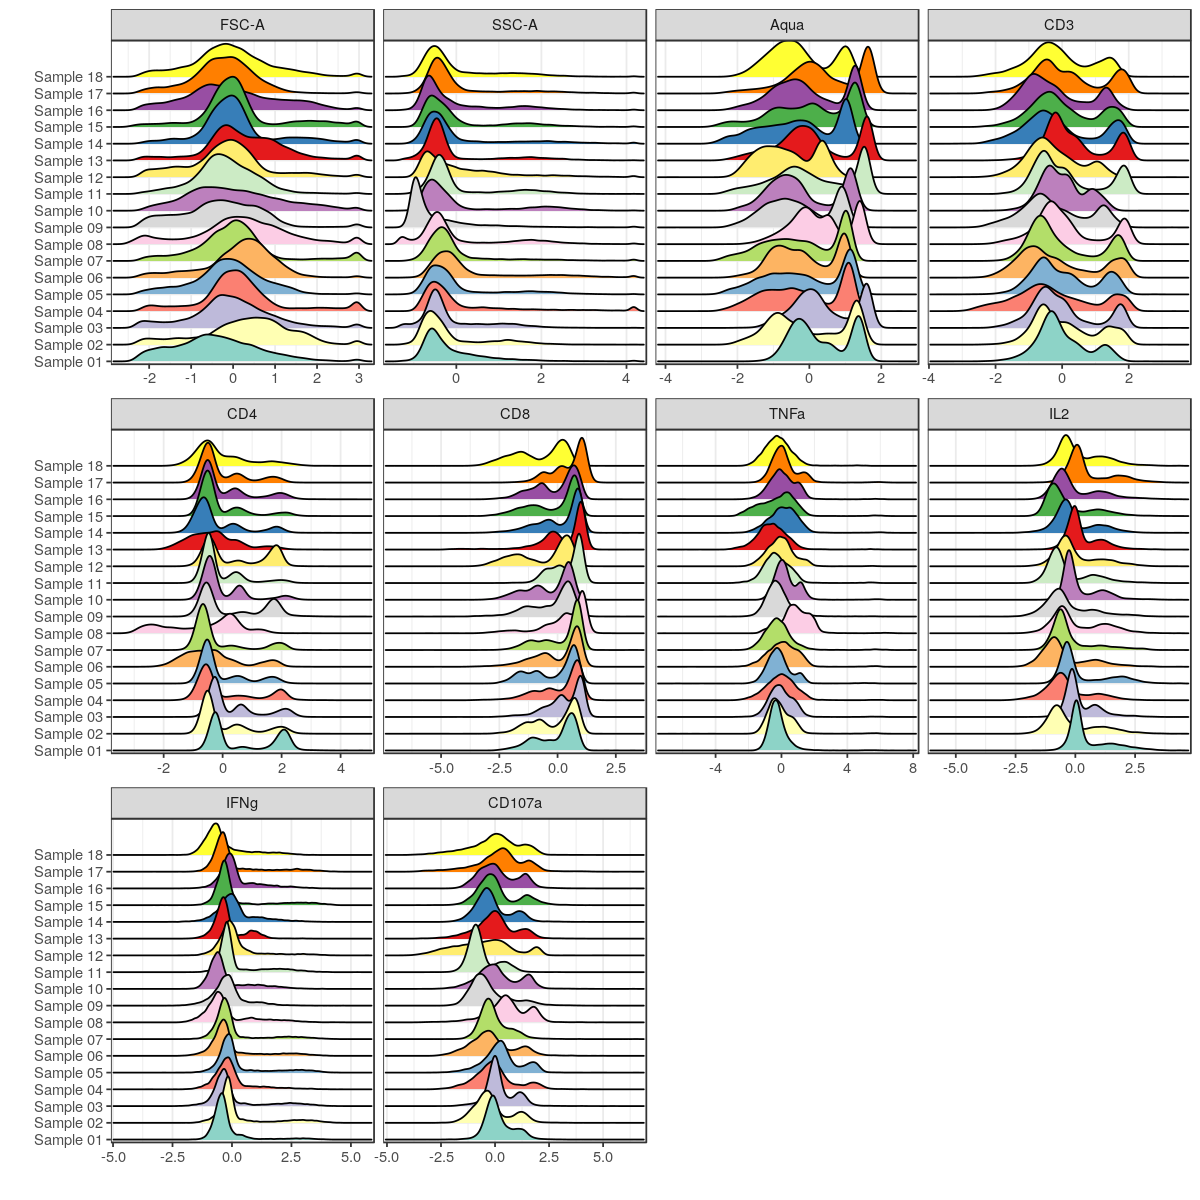

In [41]:
### set data and factor levels
dat = dat_mpsk %>% 
    gather(marker, value, -sample, -cluster)
dat$sample = paste("Sample", dat$sample)
dat$marker = factor(dat$marker, levels = markers$label)

### set manual colors
cols = c(brewer.pal(12, "Set3"), brewer.pal(6, "Set1"))
names(cols) = paste("Sample", unique(C2))

### set density ggplot
gp = ggplot(dat, aes(x = value, y = sample, fill = sample)) +
    geom_density_ridges(scale = 3) + 
    scale_fill_manual(values = cols) +
    scale_y_discrete(expand=c(0.01, 0)) +
    scale_x_continuous(expand=c(0.01, 0)) +
    facet_wrap(~marker, scales = "free_x") +
    theme_bw() +
    theme(legend.position = "none") +
    labs(y = "", x = "")
    
### visualize the plot
options(repr.plot.width = 10, repr.plot.height = 10)
print(gp)

Picking joint bandwidth of 0.114
Picking joint bandwidth of 0.0742
Picking joint bandwidth of 0.135
Picking joint bandwidth of 0.136
Picking joint bandwidth of 0.124
Picking joint bandwidth of 0.131
Picking joint bandwidth of 0.109
Picking joint bandwidth of 0.12
Picking joint bandwidth of 0.062
Picking joint bandwidth of 0.113


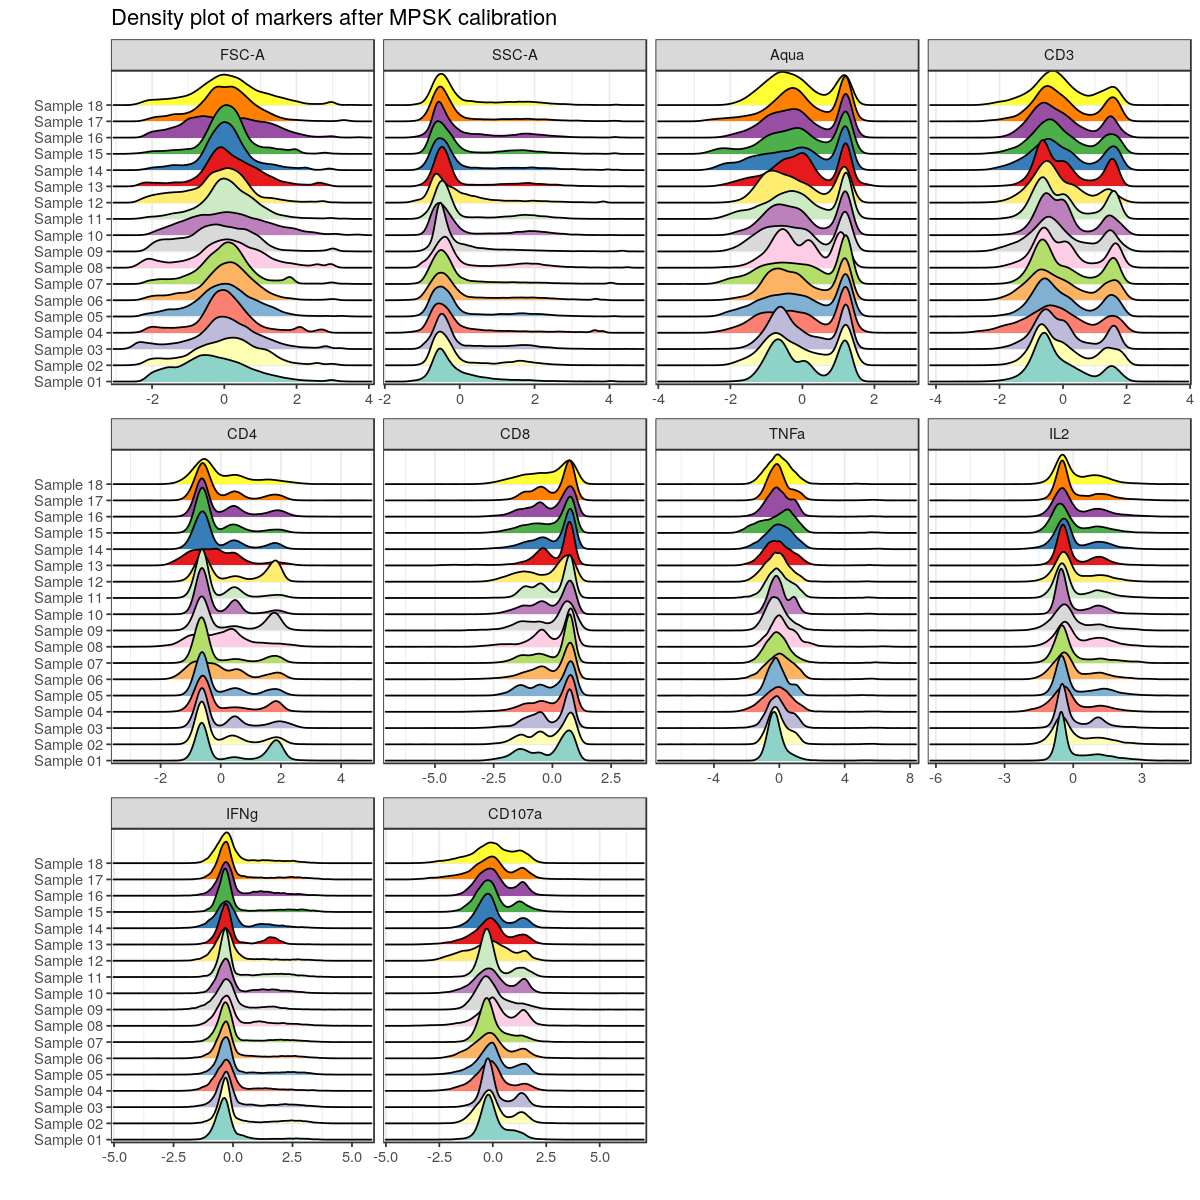

In [42]:
### set data and factor levels
dat = dat_mpsk_cal %>% 
    gather(marker, value, -sample, -cluster)
dat$sample = paste("Sample", dat$sample)
dat$marker = factor(dat$marker, levels = markers$label)

### set manual colors
cols = c(brewer.pal(12, "Set3"), brewer.pal(6, "Set1"))
names(cols) = paste("Sample", unique(C2))

### set density ggplot
gp = ggplot(dat, aes(x = value, y = sample, fill = sample)) +
    geom_density_ridges(scale = 3) + 
    scale_fill_manual(values = cols) +
    scale_y_discrete(expand=c(0.01, 0)) +
    scale_x_continuous(expand=c(0.01, 0)) +
    facet_wrap(~marker, scales = "free_x") +
    theme_bw() +
    theme(legend.position = "none") +
    labs(y = "", x = "", title = "Density plot of markers after MPSK calibration")
    
### visualize the plot
options(repr.plot.width = 10, repr.plot.height = 10)
print(gp)

Picking joint bandwidth of 0.114
Picking joint bandwidth of 0.0782
Picking joint bandwidth of 0.136
Picking joint bandwidth of 0.141
Picking joint bandwidth of 0.1
Picking joint bandwidth of 0.134
Picking joint bandwidth of 0.11
Picking joint bandwidth of 0.117
Picking joint bandwidth of 0.0642
Picking joint bandwidth of 0.115


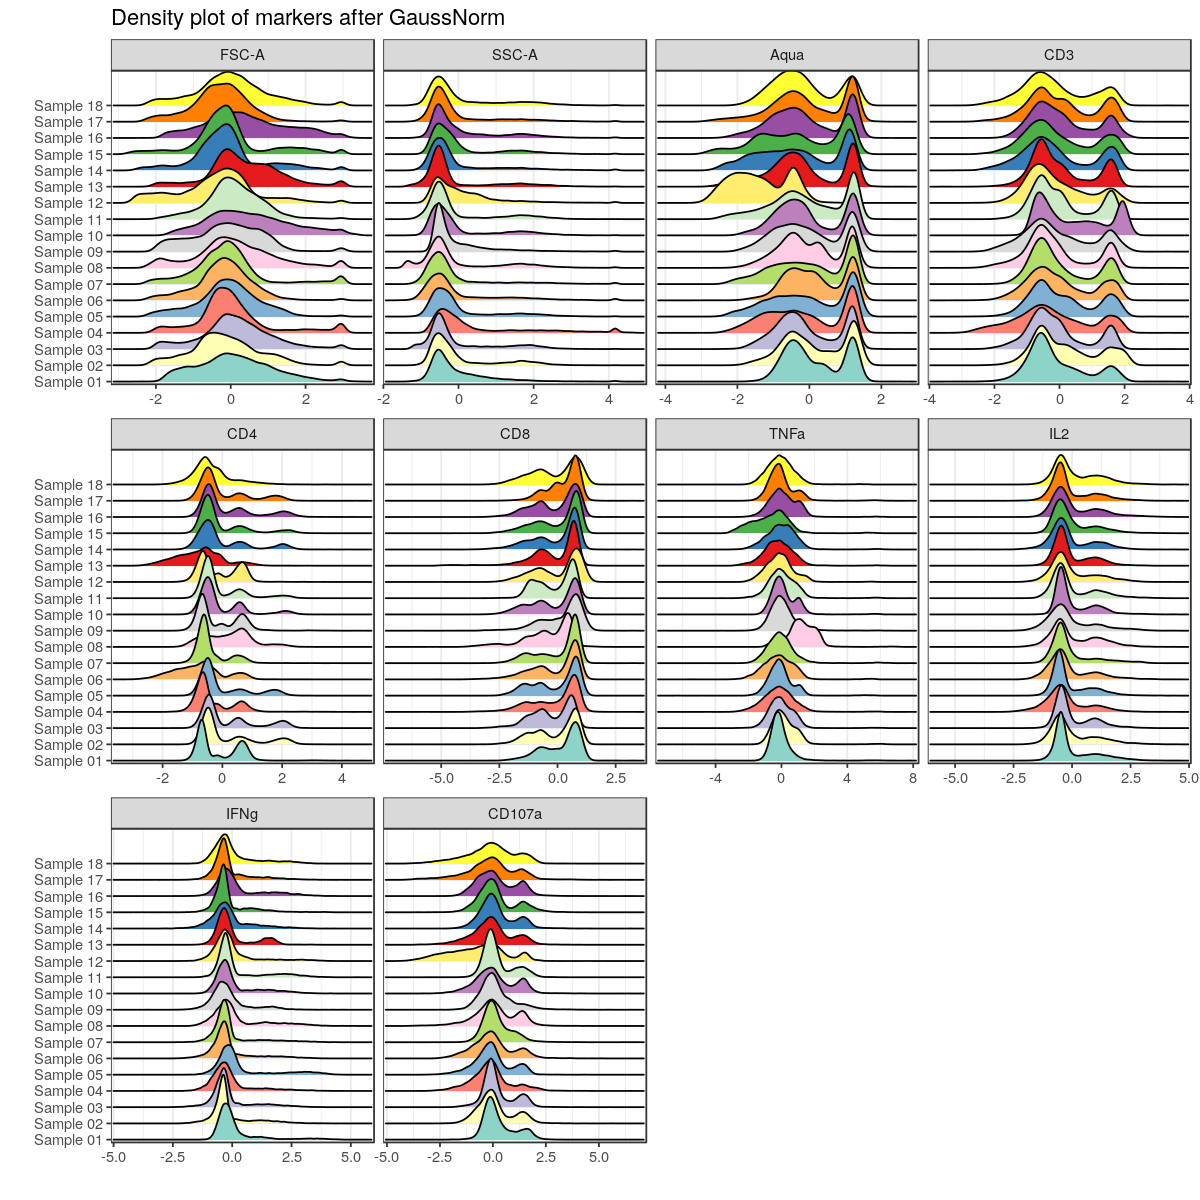

In [43]:
### set data and factor levels
dat = lapply(1:length(set_norm$flowset), function(idx){
    frame      = set_norm$flowset[[idx]]
    dat        = exprs(frame) %>% as.data.frame
    dat$sample = identifier(frame)
    return(dat)
}) # end lapply
dat = do.call(bind_rows, dat)
dat = dat %>% gather(marker, value, -sample)
dat$marker = factor(dat$marker, levels = markers$label)

### set manual colors
cols = c(brewer.pal(12, "Set3"), brewer.pal(6, "Set1"))
names(cols) = paste("Sample", unique(C2))

### set density ggplot
gp = ggplot(dat, aes(x = value, y = sample, fill = sample)) +
    geom_density_ridges(scale = 3) + 
    scale_fill_manual(values = cols) +
    scale_y_discrete(expand=c(0.01, 0)) +
    scale_x_continuous(expand=c(0.01, 0)) +
    facet_wrap(~marker, scales = "free_x") +
    theme_bw() +
    theme(legend.position = "none") +
    labs(y = "", x = "", title = "Density plot of markers after GaussNorm")
    
### visualize the plot
options(repr.plot.width = 10, repr.plot.height = 10)
print(gp)

Recheck the plot above using the densityplot from flowViz package

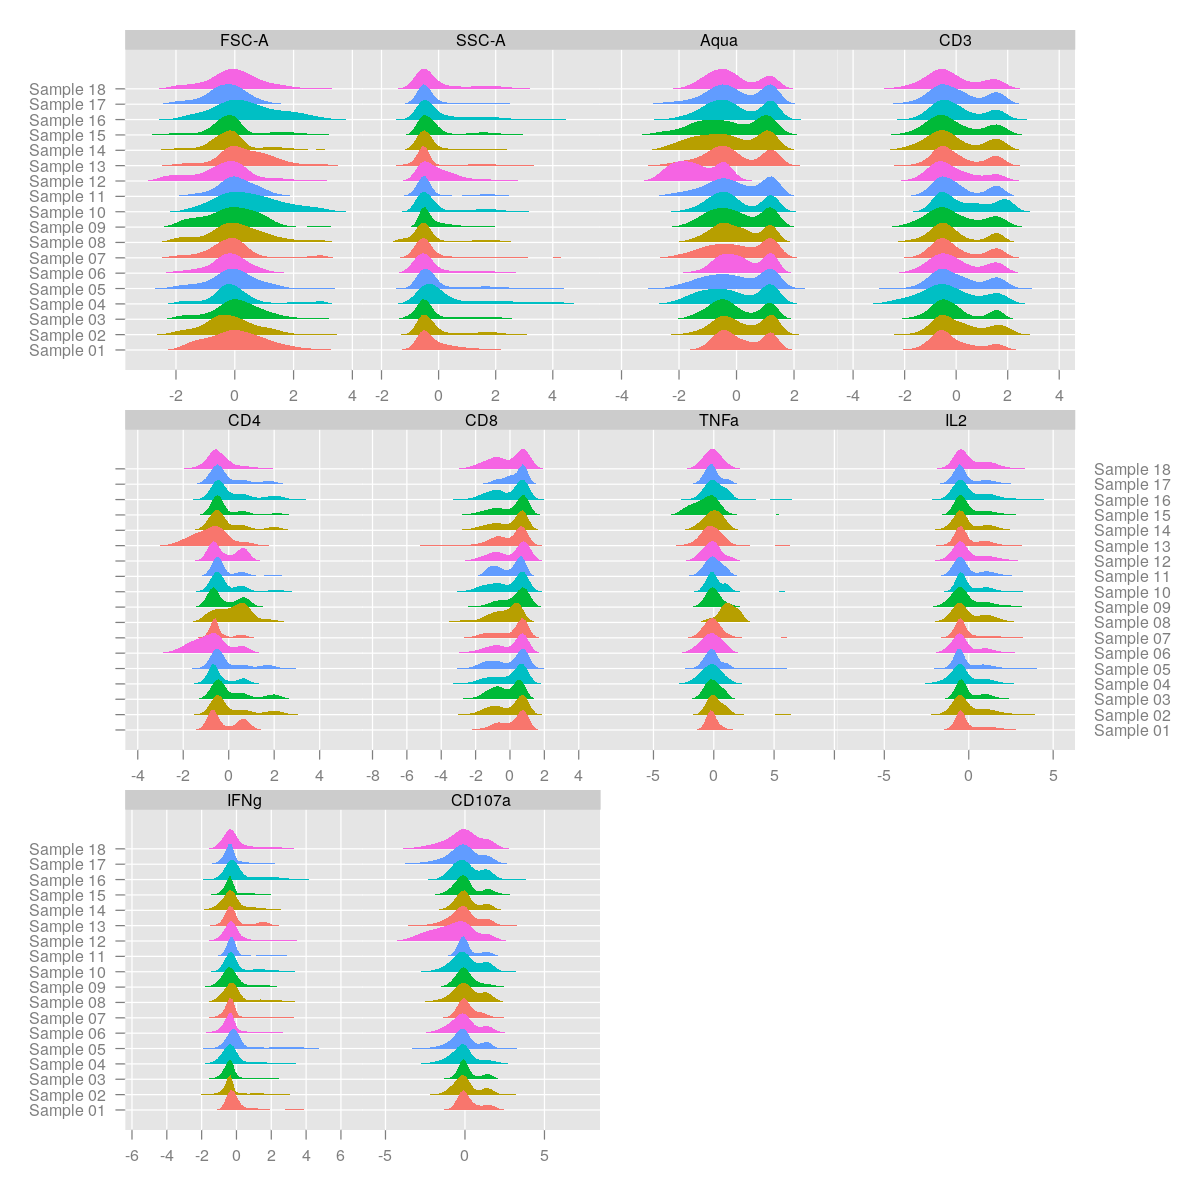

In [46]:
options(repr.plot.width = 10, repr.plot.height = 10)
densityplot(~., set_norm$flowset, channels = markers$label)